# import package

In [1]:
# 資料處理
import pandas as pd
import numpy as np
# 模型讀取、影像讀取
from keras.models import load_model
from keras.preprocessing import image
# 載入模型
from keras.models import Sequential
from keras.models import model_from_json
# 進度條
from tqdm import tqdm

Using TensorFlow backend.


# 影像

## 定義讀取影像

In [2]:
def load_image(file_name, dataset_name, dataset_path, input_size, array_name):
    data = pd.read_csv(file_name)
    dataset_name = []
    for i in tqdm(range(data.shape[0])):
        # target_size為載入圖片後將大小縮放至設定的大小
        img = image.load_img(dataset_path + data["File_name"][i], 
                             target_size = input_size)
        img = image.img_to_array(img)
        img = img/255 # 圖像歸一化(x-0/255-0)
        dataset_name.append(img)
    array_name = np.array(dataset_name)
    return array_name

## 執行讀取影像

In [3]:
train_image = load_image("D:/10979104/碩論程式整理/data_csv/train_image.csv"
                         , "train_image"
                         , "D:/10979104/碩論程式整理/train_data/"
                         , (299,299,3)
                         , "X_train")

valid_image = load_image("D:/10979104/碩論程式整理/data_csv/valid_image.csv"
                         , "valid_image"
                         , "D:/10979104/碩論程式整理/valid_data/"
                         , (299,299,3)
                         , "X_valid")

test_image = load_image("D:/10979104/碩論程式整理/data_csv/test_image.csv"
                         , "test_image"
                         , "D:/10979104/碩論程式整理/test_data/"
                         , (299,299,3)
                         , "X_test")

100%|█████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:06<00:00, 172.36it/s]


## 設定圖片標籤

In [4]:
train_label = pd.read_csv("D:/10979104/碩論程式整理/data_csv/train_label.csv")
valid_label = pd.read_csv("D:/10979104/碩論程式整理/data_csv/valid_label.csv")
test_label = pd.read_csv("D:/10979104/碩論程式整理/data_csv/test_label.csv")

# 模型

## 載入模型、讀取權重

In [5]:
def load_model(file_name, weight):
    with open(file_name, "r")as text_file:
        json_string = text_file.read()
        model = Sequential()
        model = model_from_json(json_string)
        model.load_weights(weight, by_name = False)
    return model

In [6]:
model = load_model("CNN_50_b100_Adam.json", "CNN_50_b100_Adam.h5")

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 295, 295, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 147, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 143, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 71, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 67, 67, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 128)      

# 評估

## 評估需要的package

In [8]:
from sklearn.metrics import confusion_matrix,\
                            classification_report,\
                            accuracy_score,\
                            average_precision_score,\
                            precision_score,\
                            f1_score,\
                            recall_score,\
                            cohen_kappa_score,\
                            roc_curve, roc_auc_score, auc

## 預測結果與實際結果

In [48]:
prediction = model.predict_classes(test_image)
a = test_label.values.tolist()
actual = []

for i in tqdm(range(len(a))):
    if a[i][0] == 1:
        actual.append(0)
    elif a[i][1] == 1:
        actual.append(1)
    elif a[i][2] == 1:
        actual.append(2)
    elif a[i][3] == 1:
        actual.append(3)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:00<?, ?it/s]


## 混淆矩陣

In [50]:
confusion_m = confusion_matrix(actual, prediction)

In [52]:
confusion_m

array([[221,  13,  22,   4],
       [ 13, 217,  27,   3],
       [  9,  32, 218,   1],
       [  3,   4,   7, 246]], dtype=int64)

In [53]:
target_name = test_label.columns

In [55]:
print(classification_report(actual, prediction, target_names=target_name, digits=4))

                 precision    recall  f1-score   support

          COVID     0.8984    0.8500    0.8735       260
   Lung_Opacity     0.8158    0.8346    0.8251       260
         Normal     0.7956    0.8385    0.8165       260
Viral_Pneumonia     0.9685    0.9462    0.9572       260

       accuracy                         0.8673      1040
      macro avg     0.8696    0.8673    0.8681      1040
   weighted avg     0.8696    0.8673    0.8681      1040



In [70]:
confusion_m_df = pd.DataFrame(confusion_m, index=target_name, columns=target_name)

## 混淆矩陣圖

In [56]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

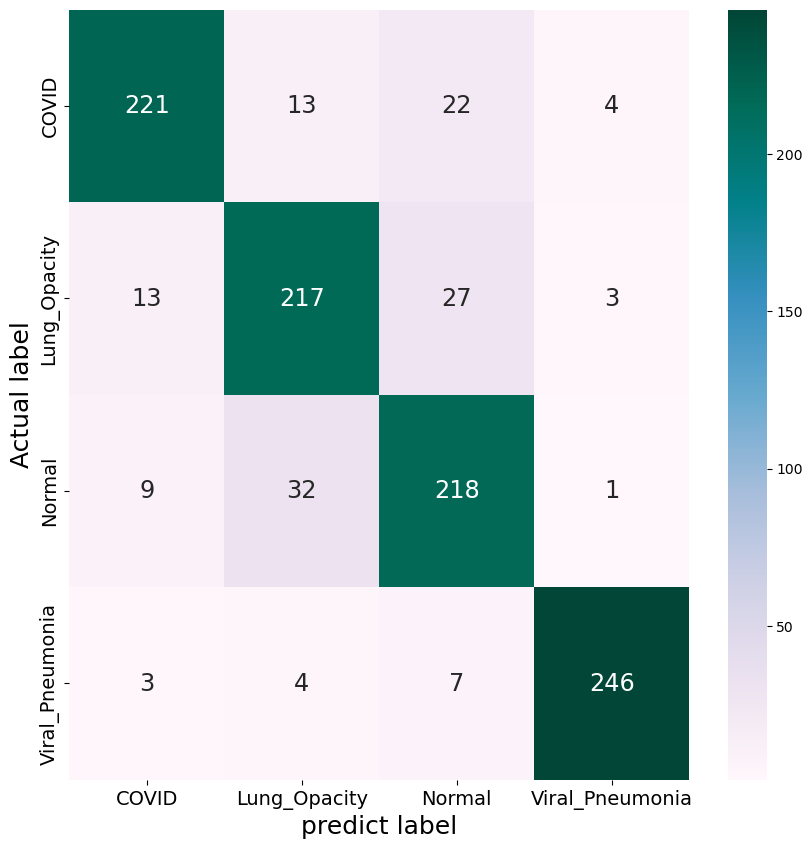

In [80]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion_m_df, 
            annot = True, 
            annot_kws={"size": "xx-large"}, 
            cmap="PuBuGn",
            fmt="g",
            xticklabels=True,
            yticklabels=True)
plt.ylabel('Actual label', fontsize=18)
plt.xlabel('predict label', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

# 評估模型

## 各項評估指標

### Micro & Macro precision、recall、F1-score

In [81]:
print('------Micro------')
print('Micro precision', precision_score(actual, prediction, average='micro'))
print('Micro recall', recall_score(actual, prediction, average='micro'))
print('Micro f1-score', f1_score(actual, prediction, average='micro'))

------Micro------
Micro precision 0.8673076923076923
Micro recall 0.8673076923076923
Micro f1-score 0.8673076923076923


In [82]:
print('------Macro------')
print('Micro precision', precision_score(actual, prediction, average='macro'))
print('Micro recall', recall_score(actual, prediction, average='macro'))
print('Micro f1-score', f1_score(actual, prediction, average='macro'))

------Macro------
Micro precision 0.8695719580970316
Micro recall 0.8673076923076923
Micro f1-score 0.868072671981079


### kappa 檢測一致性

In [83]:
print("kappa score", cohen_kappa_score(actual, prediction))

kappa score 0.823076923076923


## ROC Curve

### ROC auc

In [106]:
y_score = model.predict_proba(test_image)

In [108]:
# a = test_label.values.tolist() 預測與實際結果處已設立將其轉為list
b = np.array(a)
fpr, tpr, thresholds = roc_curve(b.ravel(), y_score.ravel())
auc_value = auc(fpr, tpr)

print('手動計算auc:', auc_value)

手動計算auc: 0.9765213572485206


### ROC Curve 圖

In [109]:
mpl.rcParams['font.sans-serif'] = u'SimSun' #用來正常顯示中文標籤， SimHei代表黑體
mpl.rcParams['axes.unicode_minus'] = False #用來正常顯示負號

C:\Users\Uwei\anaconda3\envs\py_37_tf_2\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


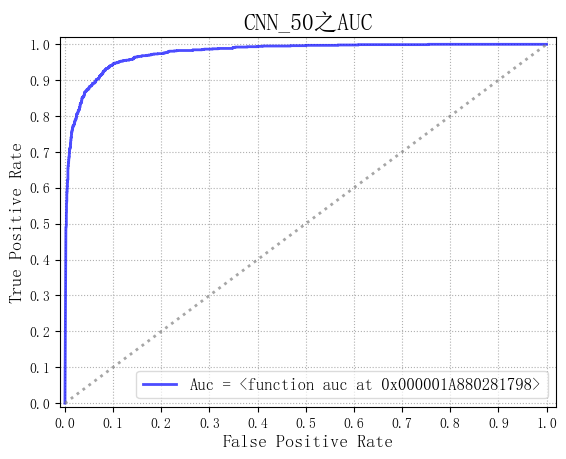

In [124]:
'''FPR為X軸(橫坐標)，TPR為Y軸(縱座標)'''
plt.plot(fpr, tpr, c = 'b', lw = 2, alpha = 0.7, label = 'Auc = {}'.format(auc))
# ls -> linestyle ; lw -> linewidth ; alpha = 對角線透明度
plt.plot((0, 1), (0, 1), c = '#808080', lw = 2, ls = ':', alpha = 0.7)
plt.xlim((-0.01, 1.02)) # x軸刻度
plt.ylim((-0.01, 1.02)) # y軸刻度
plt.xticks(np.arange(0, 1.1, 0.1)) # x軸刻度標籤
plt.yticks(np.arange(0, 1.1, 0.1)) # y軸刻度標籤
plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.grid(b=True, ls=':') # 畫出網格 b=True表示顯示網格線
# loc表示圖標放置位置 ； fancybox表示圖標是否有框線 ； framealpha圖標框線透明度
plt.legend(loc = 'lower right', fancybox = True, framealpha = 0.7, fontsize = 12)
plt.title('CNN_50之AUC', fontsize = 17)
plt.show()

## 讀取訓練紀錄

In [126]:
import pickle
with open("D:\\10979104\\碩論程式整理\\cnn_50_b100_history", "rb") as file_pi:
    history = pickle.load(file_pi)

In [132]:
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history["val_accuracy"]
val_loss = history["val_loss"]

In [161]:
print(max(train_acc))
print(max(val_acc))
print(min(train_loss))
print(min(val_loss))

0.9738582
0.8737980723381042
0.070017931736052
0.4160627367762992


###  acc & loss 圖

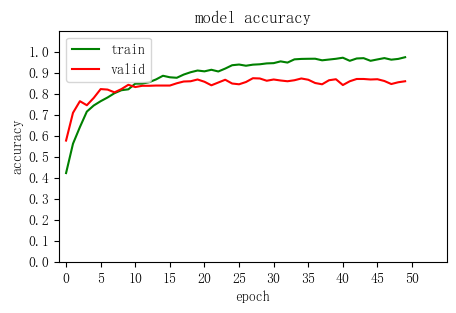

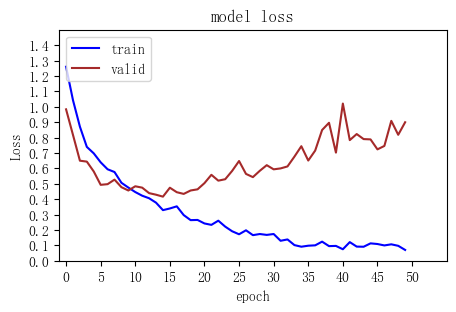

In [162]:
fig1, ax1 = plt.subplots(figsize = (5, 3))
plt.plot(train_acc, label='train_accuracy', color='green')
plt.plot(val_acc, label='val_accuracy', color='red')
plt.xlim((-1, 55)) # x軸刻度
plt.ylim((0, 1.1)) # y軸刻度
plt.xticks(np.arange(0, 55, 5)) # x軸刻度標籤
plt.yticks(np.arange(0, 1.1, 0.1)) # y軸刻度標籤
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

fig2, ax2 = plt.subplots(figsize = (5, 3))
plt.plot(train_loss, label='train_loss', color='blue')
plt.plot(val_loss, label='val_loss', color='brown')
plt.xlim((-1, 55)) # x軸刻度
plt.ylim((0, 1.5)) # y軸刻度
plt.xticks(np.arange(0, 55, 5)) # x軸刻度標籤
plt.yticks(np.arange(0, 1.5, 0.1)) # y軸刻度標籤
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()